In [1]:
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os
import glob
import xml.etree.ElementTree as ET
import numpy as np

ROOT_PATH = "training/data/cut_video"
TF_RECORD_FILE = "training/cup_dataset.tfrecord"

In [2]:
def xml_to_df(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

def group_by_image(path, df):
    for img_file in glob.glob(path + "/*.png"):
        filename = os.path.basename(img_file)
        img = cv2.imread(img_file,1)
        detections = {'ymin':[],'xmin':[],'ymax':[],'xmax':[]}
        for _,row in df.loc[df['filename'] == filename].iterrows():
            detections['ymin'].append(row.ymin)
            detections['xmin'].append(row.xmin)
            detections['ymax'].append(row.ymax)
            detections['xmax'].append(row.xmax)
        
        yield {'img': img, 'detections': detections, 'filename': filename}

        
df = xml_to_df(ROOT_PATH + "/annotations")

[sample['filename'] for sample in group_by_image(ROOT_PATH,df) if len(sample['detections']) == 0]

[]

In [8]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

writer = tf.python_io.TFRecordWriter(TF_RECORD_FILE)

for sample in group_by_image(ROOT_PATH,df):
    
    height = sample['img'].shape[0]
    width = sample['img'].shape[1]
    
    detections = sample['detections']
    example = tf.train.Example(features=tf.train.Features(feature={
        'xmin': tf.train.Feature(int64_list=tf.train.Int64List(value=detections['xmin'])),
        'ymin': tf.train.Feature(int64_list=tf.train.Int64List(value=detections['ymin'])),
        'ymax': tf.train.Feature(int64_list=tf.train.Int64List(value=detections['ymax'])),
        'xmax': tf.train.Feature(int64_list=tf.train.Int64List(value=detections['xmax'])),
        'image_raw': _bytes_feature(sample['img'].tostring()),
        'height': _int64_feature(height),
        'width': _int64_feature(width),
    }))
    
    writer.write(example.SerializeToString())

writer.close()

# Read for training

In [17]:
def read_and_decode(filename_queue, IMAGE_TARGET_SIZE=(1024, 720)):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'xmin': tf.VarLenFeature(dtype=tf.int64),
        'ymin': tf.VarLenFeature(dtype=tf.int64),
        'xmax': tf.VarLenFeature(dtype=tf.int64),
        'ymax': tf.VarLenFeature(dtype=tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    #detections = tf.decode_raw(features['detections'], tf.uint8)
    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    xmins = tf.cast(features['xmin'], tf.int32)
    ymins = tf.cast(features['ymin'], tf.int32)
    xmaxs = tf.cast(features['xmax'], tf.int32)
    ymaxs = tf.cast(features['ymax'], tf.int32)
    
    image_shape = tf.stack([height, width, 3])
    #detections_shape = tf.stack([detections_count, 4])
    
    image = tf.reshape(image, image_shape)
    #detections = tf.reshape(detections, detections_shape)
    
    image_size_const = tf.constant((IMAGE_TARGET_SIZE[0], IMAGE_TARGET_SIZE[1], 3), dtype=tf.int32)
    
    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
    resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
                                           target_height=IMAGE_TARGET_SIZE[0],
                                           target_width=IMAGE_TARGET_SIZE[1])
    
    #todo: resize detection
    
    
    images, xmins, ymins, xmaxs, ymaxs = tf.train.shuffle_batch( [resized_image, xmins, ymins, xmaxs, ymaxs],
                                                 batch_size=2,
                                                 capacity=30,
                                                 num_threads=2,
                                                 min_after_dequeue=10)
    
    return images, [xmins, ymins, xmaxs, ymaxs]

[SparseTensorValue(indices=array([[0, 0],
       [1, 0]]), values=array([242, 831], dtype=int32), dense_shape=array([2, 1])), SparseTensorValue(indices=array([[0, 0],
       [1, 0]]), values=array([18, 23], dtype=int32), dense_shape=array([2, 1])), SparseTensorValue(indices=array([[0, 0],
       [1, 0]]), values=array([ 644, 1212], dtype=int32), dense_shape=array([2, 1])), SparseTensorValue(indices=array([[0, 0],
       [1, 0]]), values=array([450, 369], dtype=int32), dense_shape=array([2, 1]))]


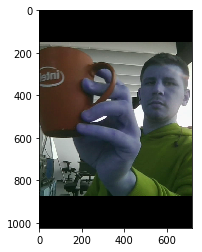

[SparseTensorValue(indices=array([[1, 0]]), values=array([817], dtype=int32), dense_shape=array([2, 1])), SparseTensorValue(indices=array([[1, 0]]), values=array([304], dtype=int32), dense_shape=array([2, 1])), SparseTensorValue(indices=array([[1, 0]]), values=array([1165], dtype=int32), dense_shape=array([2, 1])), SparseTensorValue(indices=array([[1, 0]]), values=array([628], dtype=int32), dense_shape=array([2, 1]))]


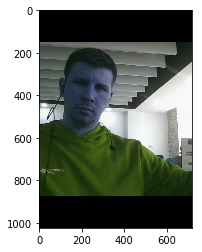

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: shuffle_batch_2/random_shuffle_queue_enqueue = QueueEnqueueV2[Tcomponents=[DT_UINT8, DT_INT64, DT_INT64, DT_INT64, DT_INT64], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](shuffle_batch_2/random_shuffle_queue, Squeeze_3, shuffle_batch_2/ExpandDims, shuffle_batch_2/ExpandDims_1, shuffle_batch_2/ExpandDims_2, shuffle_batch_2/ExpandDims_3)]]


In [18]:

filename_queue = tf.train.string_input_producer(
    [TF_RECORD_FILE], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, detections = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(2):
        img, detect = sess.run([image, detections])
        
        print(detect)
        
        plt.imshow(img[0, :, :, :])
        plt.show()

In [ ]:
np.zeros((1,3), dtype='uint8')